In [1]:
from pandas import DataFrame
import pandas
# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = "all"

from importlib import reload
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from tqdm import tqdm
import mxp_tools.labs.watt_balance
import mxp_tools.fit

In [2]:
matplotlib.rcParams.update({'font.size': 18, 'text.usetex': True})

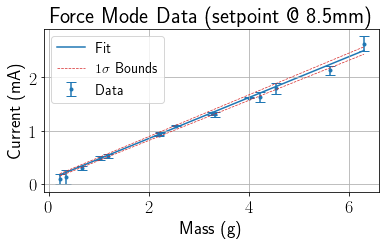

params [0.38382445 0.08100038] param errors [0.00762468 0.02129963]
Reduced chi^2: 1.35
PTE: 0.8266
25.55 +- 0.51 kgm/s^2A
25.547617, 0.507504


In [3]:
reload(mxp_tools.labs.watt_balance)
ForceMode = mxp_tools.labs.watt_balance.ForceMode

fm = ForceMode('data/20190502-force-data.csv')
# fm.raw_data
# fm.raw_data.columns

# fig = plt.figure(figsize=(12,4))
# fm.process()
# fm.plot(fig)
# plt.show()
# fm

fm.process()
# print(fm.I.value, fm.I.err)
bl = fm.get_BL()
bl.value, bl.err

fig = plt.figure(figsize=(6,3))
ax = fig.add_subplot(111)
fm.analysis.plot(ax)

ax.set_xlabel('Mass (g)')
ax.set_ylabel('Current (mA)')
ax.set_title('Force Mode Data (setpoint @ 8.5mm)')
ax.legend(fontsize=14)
# ax.text(5, -1.5, 'Measured BL: $24.32336\\pm7\\times 10^{-5}$ $\\mathrm{(gm/s^2A)}$')
plt.show()

print(fm.analysis)
print(fm.get_BL())
bl = fm.get_BL()
print('{:.6f}, {:.6f}'.format(bl.value, bl.err))

In [4]:
reload(mxp_tools.labs.watt_balance)
reload(mxp_tools.fit)
VelocityMode = mxp_tools.labs.watt_balance.VelocityMode
Analysis = mxp_tools.fit.Analysis

manifest = pandas.read_csv('data/manifest/velocity_manifest.csv')
fnames = []
list(manifest)
fnames = manifest.loc[manifest['use']==1][['Name', 'left', 'right']]

data = []
for row in tqdm(fnames.iterrows()):
    fname, left, right = list(row[1])
    V = VelocityMode('data/'+fname, [left, -right])
    V.data.process()
    summary = V.summary()
    data.append({
        'fname': fname,
        'mean_pos': summary['mean_pos'],
        'slope': summary['slope'].value*1000,
        'slope_err': summary['slope'].err*1000
    })
    
# data

data = DataFrame(data)

x = data['mean_pos'].as_matrix()
y = data['slope'].as_matrix()
yerr = data['slope_err'].as_matrix()


0it [00:00, ?it/s]/home/michael/Documents/College/Phys_4052/mxp-tools/mxp_tools/labs/watt_balance.py:195: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  position = data[0].as_matrix()
/home/michael/Documents/College/Phys_4052/mxp-tools/mxp_tools/labs/watt_balance.py:196: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  voltage = data[2].as_matrix()
/home/michael/Documents/College/Phys_4052/mxp-tools/mxp_tools/labs/watt_balance.py:210: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  x_raw = raw_data[1].as_matrix()
/home/michael/Documents/College/Phys_4052/mxp-tools/mxp_tools/labs/watt_balance.py:211: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  y_raw = raw_data[3].as_matrix()
32it [00:13,  2.48it/s]
/home/michael/Documents/College/jupyter/venv/lib/python3.6/site-packages/ipykernel_launcher.py:28: FutureWarn

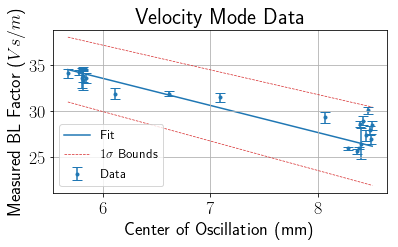

params [-2.946132   51.20520733] param errors [0.25972692 2.04704554]
Reduced chi^2: 16.06
PTE: 1.0000
26.2 +- 3.0 V s/m
(0.024091037040207864, 0.20442789682962892)
(-0.02352431196921217, -1.212736863188204)


In [5]:
i = np.where(x>7)
yerr2 = yerr.copy()*1
yerr2[np.where(y>26)] *= 8
i = x>5
i[np.where((x<5)&(y<30))] = False
i[np.where((x>8)&(y>32))] = False
i[np.where((x<7)&(y<30))] = False
i[np.where((y>35))] = False

i = np.where(i)

analysis = Analysis.new_2param(x[i], y[i], yerr2[i])

fig = plt.figure(figsize=(6,3))
ax = fig.add_subplot(111)
analysis.plot(ax, plot_bounds=True)

ax.set_xlabel('Center of Oscillation (mm)')
ax.set_ylabel('Measured BL Factor ($Vs/m$)')
bl = analysis.model.get_value(8.5)*1000
bl = '{:.1f}\\pm{:.1f}'.format(bl.value, bl.err)
# ax.text(5.8, 24.5, 'Predicted BL @ 8.5: $%s$ $(Vs/m)$' % bl, {'size': 18})
ax.set_title('Velocity Mode Data')
ax.legend(fontsize=13)
plt.show()
print(analysis)

bl = analysis.model.get_value(8.5)
bl.unit = V.data.get_BL().unit
# bl.fmt = '{:.1f} +- {:.1f} {}'
print(bl)
print(analysis.model.get_value(8.5).eval(fm.get_BL().value))
print(fm.get_BL().eval(analysis.model.get_value(8.5).value))

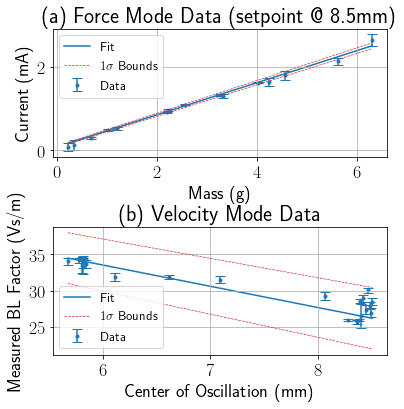

In [6]:
fig = plt.figure(figsize=(6,6))
fig.subplots_adjust(hspace=0.55)
axes = fig.subplots(2,1)

ax = axes[0]
fm.analysis.plot(ax)
ax.set_xlabel('Mass (g)')
ax.set_ylabel('Current (mA)')
ax.set_title('(a) Force Mode Data (setpoint @ 8.5mm)')
ax.legend(fontsize=13)

ax = axes[1]
analysis.plot(ax, plot_bounds=True)
ax.set_xlabel('Center of Oscillation (mm)')
ax.set_ylabel('Measured BL Factor (Vs/m)')
ax.set_title('(b) Velocity Mode Data')
ax.legend(fontsize=13)
plt.show()

In [7]:
bl1 = fm.get_BL()
bl2 = analysis.model.get_value(8.5)
# bl2.unit = 'Vs/m'
bl1, bl2

bl = bl1.value/bl2.value
blerr = np.sqrt((bl1.err/bl2.value)**2+(bl2.err*bl1.value/bl2.value**2)**2)
Value(bl, blerr, '')

NameError: name 'Value' is not defined

In [ ]:
# for row in fnames.iterrows():
#     fname, left, right = list(row[1])
#     V = VelocityMode('data/'+fname, [left, -right])
#     V.data.process()
#     fig = plt.figure()
#     ax = fig.add_subplot(111)
#     V.data.analysis.plot(ax, plot_ebars=False)
#     print(fname)
#     plt.show()

In [ ]:
reload(mxp_tools.labs.watt_balance)
reload(mxp_tools.fit)
VelocityMode = mxp_tools.labs.watt_balance.VelocityMode
Analysis = mxp_tools.fit.Analysis
fname, left, right = list(fnames.loc[fnames['Name'] == '20190503-vel-13.csv'].iloc[0])
print(fname, left, right)
V = VelocityMode('data/'+fname, [left, -right])
# V.process()
V.data.process()

fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_ylabel('Standardized Amplitude')
ax.legend(loc='upper right')
V.plot_time_series(V.data.stage1_norm, ax, 500, legend_loc='upper right')

fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_ylabel('Standardized Amplitude')
V.plot_time_series(V.data.stage2_norm, ax, 500, legend_loc='upper right')
ax.text(0.1, 1.1, 'Shifted by %dms' % (V.data.shift*10), bbox=dict(facecolor='white', alpha=0.5))
plt.show()

fig = plt.figure(figsize=(6,6))
fig.subplots_adjust(hspace=.35)
axs = fig.subplots(2, 1)

ax = axs[0]
ax.legend(loc='upper right')
V.plot_time_series(V.data.stage1_norm, ax, 500, legend_loc='upper right')
ax.set_ylabel('Standardized Amplitude')
ax.set_xlabel('')
ax.set_title('(a) Before shifting')

ax = axs[1]
V.plot_time_series(V.data.stage2_norm, ax, 500, legend_loc='upper right')
ax.text(0.1, 1.1, 'Shifted by %dms' % (V.data.shift*10), bbox=dict(facecolor='white', alpha=0.5))
ax.set_ylabel('Standardized Amplitude')
ax.set_xlabel('time (s)')
ax.set_title('(b) After shifting')
plt.show()

In [ ]:
self = V.data
xy, xt = self.load_data()
# dx = self._velocity_diff(xy[:,0], xt)
# dx = self._velocity_savgol(xy[:,0])
# plt.plot(xy[:500,0])
# plt.show()

# plt.plot(dx[:500])
# plt.show()

# x = self._data_savgol(xy[:,0], deriv=0)
# plt.plot(x[:500])
# plt.show()

fig = plt.figure(figsize=(6,2.5))
# fig.subplots_adjust(hspace=0.35)
# axes = fig.subplots(2,1)

dx1 = self._velocity_diff(xy[:,0], xt)
dx2 = self._velocity_savgol(xy[:,0])
i = np.arange(500)/100

ax = fig.add_subplot(111)
ax.plot(i, dx1[:len(i)], alpha=0.6, label='CD')
ax.plot(i, dx2[:len(i)], label='SG')
ax.legend(fontsize=13)
ax.set_title('Velocity Calculation Method')
# ax.set_title('Velocity (centered difference)')
ax.set_xlabel('time (s)')
ax.set_ylabel('Velocity (mm/s)')
# ax.set_ylim([-1.5,1.5])
ax.grid()

# ax = axes[1]
# ax.plot(i, dx2[:len(i)])
# ax.set_title('Velocity (Savitzky Golay method)')
# ax.set_ylabel('Velocity (mm/s)')
# ax.set_ylim([-1.5,1.5])
# ax.grid()
plt.show()

In [ ]:
n = 1000
x = np.linspace(0, 8*np.pi, n)
y1 = np.sin(x)
y2 = np.sin(x+np.pi/8)

fig = plt.figure(figsize=(6,10))
fig.subplots_adjust(hspace=0.55)
axes = fig.subplots(3,1)

ax = axes[0]
ax.plot(x/np.pi, y1, label='f=sin(x)')
ax.plot(x/np.pi, y2, label='g=sin(x+$\pi$/8)')
ax.set_xlabel('x ($\pi$)')
ax.set_title('(a) Input Signals')
ax.legend(fontsize=13)

ax = axes[1]
i = np.arange(-n+1, n)*8/n
corr = np.correlate(y1, y2, 'full')
ax.plot(i, corr)
ax.set_ylabel('$(f*g)(\Delta x)$ ($\pi$)')
ax.set_xlabel('$\Delta x$')
ax.set_title('(b) Cross-Correlation')

s = np.arange(-n+1,n)[np.argmax(corr)]
ax = axes[2]
ax.plot(x[:-s]/np.pi, y1[s:])
ax.plot(x[:-s]/np.pi, y2[:-s], '--')
ax.set_title('(c) Shifted signals')
ax.set_xlabel('x ($\pi$)')
plt.show()

i[np.argmax(corr)]

In [ ]:
reload(mxp_tools.labs.watt_balance)
reload(mxp_tools.fit)
VelocityMode = mxp_tools.labs.watt_balance.VelocityMode
Analysis = mxp_tools.fit.Analysis
fname, left, right = list(fnames.loc[fnames['Name'] == '20190503-vel-13.csv'].iloc[0])
print(fname, left, right)
V = VelocityMode('data/'+fname, [left, -right])
# V.process()
V.data.process()

fig = plt.figure(figsize=(6,2.5))
ax = fig.add_subplot(111)
V.data.analysis.plot(ax, plot_ebars=True, plot_bounds=0, line_color=True, alpha=0.6, sample_size=250)
ax.set_xlabel('Velocity (mm/s)')
ax.set_ylabel('Induced Voltage (V)')
ax.set_title('')
ax.legend(fontsize=13)
plt.show()

print(V.data.analysis)
print(V.data.analysis.yerr)
print(V.data.get_BL())
# np.mean(V.data._uncertainty(V.data.stage2[:,1])/V.data.stage2[:,1]), \
#     np.mean(V.data._uncertainty(V.data.stage2[:,0])/V.data.stage2[:,0]), \
#     V.data.stage2
V.data._uncertainty(V.data.stage2[:,1])

In [ ]:
bl = V.data.get_BL()
# bl.err, np.floor(np.log(bl.err)), np.round(550, -2)
# bl.err, np.round([bl.value, bl.err], -int(np.floor(np.log(bl.err))))
bl.err, \
    bl._round, -int(np.floor(np.log(bl.err))), bl, \
    np.round(bl.value, 3)

In [ ]:
reload(mxp_tools.fit)
Value = mxp_tools.fit.Value
print(Value(1, 0.012345)._fmt)
print(Value(27.3251, 0.076712))
print(Value(12345678, 150000)._fmt)
print(Value(1234566789e-10, 15e-5)._fmt)

In [ ]:
from mxp_tools.fit import FitLSQ
analysis = V.data.analysis
x = analysis.x
y = analysis.y
yerr = analysis.yerr
print(yerr)

_,c,_,cerr = FitLSQ.lsq_fit(x, y, yerr)
c,cerr


In [ ]:
analysis = V.data.analysis
analysis = Analysis.new(analysis.x, analysis.y, analysis.yerr/10, analysis.model.function)
analysis.plot(plt.figure().add_subplot(111), plot_ebars=False)
print(analysis)